# Import Libraries

In [6]:
import os
import time
import torch
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from torchtext import data, datasets
from torchtext.vocab import GloVe
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, LSTM, Embedding, Bidirectional, GRU, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

In [2]:
# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data Exploration

In [3]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True)
# For multi-class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [6]:
print("No. of training samples:",len(train_data.examples))
print("No. of testing samples:",len(test_data.examples))

No. of training samples: 5452
No. of testing samples: 500


In [7]:
for i in range(10):
    print(vars(train_data.examples[i]))

{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}
{'text': ['What', 'films', 'featured', 'the', 'character', 'Popeye', 'Doyle', '?'], 'label': 'ENTY'}
{'text': ['How', 'can', 'I', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?'], 'label': 'DESC'}
{'text': ['What', 'fowl', 'grabs', 'the', 'spotlight', 'after', 'the', 'Chinese', 'Year', 'of', 'the', 'Monkey', '?'], 'label': 'ENTY'}
{'text': ['What', 'is', 'the', 'full', 'form', 'of', '.com', '?'], 'label': 'ABBR'}
{'text': ['What', 'contemptible', 'scoundrel', 'stole', 'the', 'cork', 'from', 'my', 'lunch', '?'], 'label': 'HUM'}
{'text': ['What', 'team', 'did', 'baseball', "'s", 'St.', 'Louis', 'Browns', 'become', '?'], 'label': 'HUM'}
{'text': ['What', 'is', 'the', 'oldest', 'profession', '?'], 'label': 'HUM'}
{'text': ['What', 'are', 'liver', 'enzymes', '?'], 'label': 'DESC'}
{'text': ['Name', 'the', 'scar', '-', 'faced', 'bounty', 'hunter', 'of', 'The', 'Old

In [8]:
for i in range(10):
    print(vars(test_data.examples[i]))

{'text': ['How', 'far', 'is', 'it', 'from', 'Denver', 'to', 'Aspen', '?'], 'label': 'NUM'}
{'text': ['What', 'county', 'is', 'Modesto', ',', 'California', 'in', '?'], 'label': 'LOC'}
{'text': ['Who', 'was', 'Galileo', '?'], 'label': 'HUM'}
{'text': ['What', 'is', 'an', 'atom', '?'], 'label': 'DESC'}
{'text': ['When', 'did', 'Hawaii', 'become', 'a', 'state', '?'], 'label': 'NUM'}
{'text': ['How', 'tall', 'is', 'the', 'Sears', 'Building', '?'], 'label': 'NUM'}
{'text': ['George', 'Bush', 'purchased', 'a', 'small', 'interest', 'in', 'which', 'baseball', 'team', '?'], 'label': 'HUM'}
{'text': ['What', 'is', 'Australia', "'s", 'national', 'flower', '?'], 'label': 'ENTY'}
{'text': ['Why', 'does', 'the', 'moon', 'turn', 'orange', '?'], 'label': 'DESC'}
{'text': ['What', 'is', 'autism', '?'], 'label': 'DESC'}


Unique labels in training data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'DESC': 1162, 'ENTY': 1250, 'ABBR': 86, 'HUM': 1223, 'NUM': 896, 'LOC': 835}
Num unique: 6


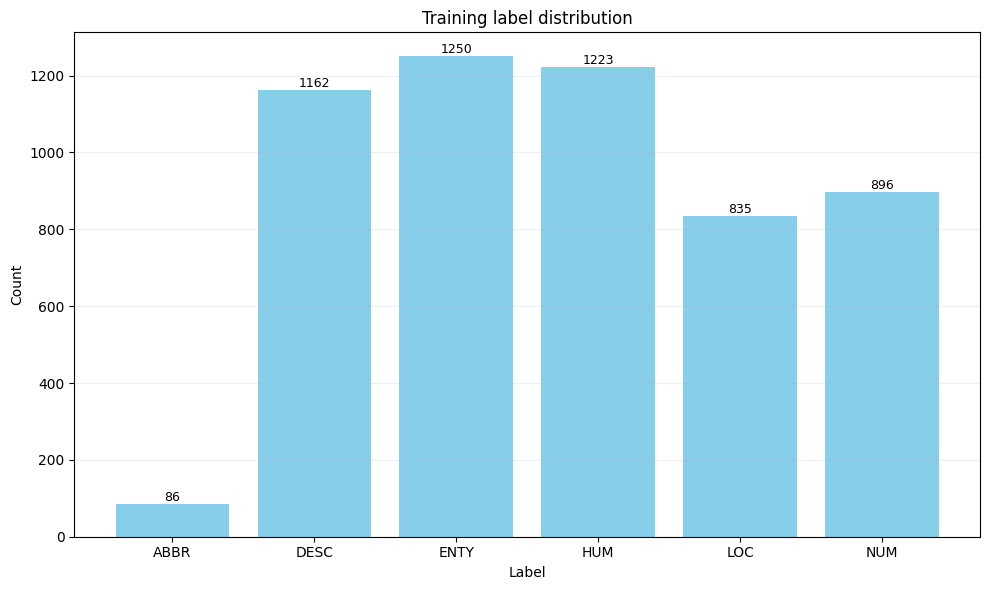

In [9]:
labels = [ex.label for ex in train_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in training data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Training label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

Unique labels in test data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'NUM': 113, 'LOC': 81, 'HUM': 65, 'DESC': 138, 'ENTY': 94, 'ABBR': 9}
Num unique: 6


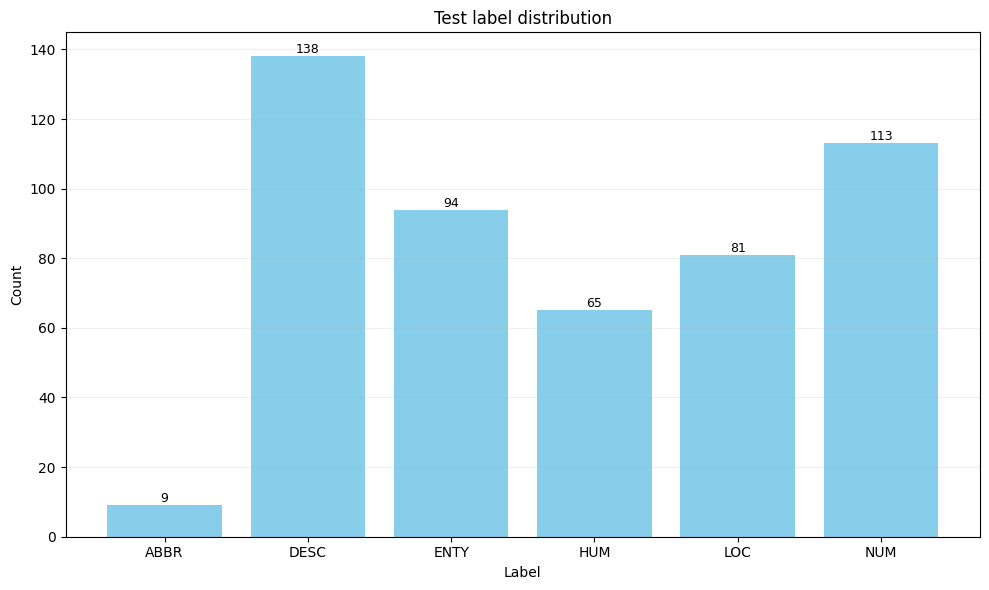

In [10]:
labels = [ex.label for ex in test_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in test data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Test label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [11]:
# Split training data into train and validation sets
all_examples = train_data.examples
all_labels = [ex.label for ex in all_examples]

train_examples, valid_examples = train_test_split(
    all_examples,
    test_size=0.2,
    random_state=42,
    stratify=all_labels,  # Ensures class proportions in both splits
)

# Rebuild torchtext Datasets using the same Fields (vocab stays the same)
train_data = data.Dataset(train_examples, fields=train_data.fields)
valid_data = data.Dataset(valid_examples, fields=train_data.fields)

# Verify each split contains all 6 categories
print("Train label counts:", Counter([ex.label for ex in train_data.examples]))
print("Valid label counts:", Counter([ex.label for ex in valid_data.examples]))

Train label counts: Counter({'ENTY': 1000, 'HUM': 978, 'DESC': 929, 'NUM': 717, 'LOC': 668, 'ABBR': 69})
Valid label counts: Counter({'ENTY': 250, 'HUM': 245, 'DESC': 233, 'NUM': 179, 'LOC': 167, 'ABBR': 17})


In [12]:
# 1) Extract raw texts and labels from torchtext Datasets
def to_texts_labels(ds):
    texts, labels = [], []
    for ex in ds.examples:
        t = ex.text
        if isinstance(t, list):
            t = " ".join(t) # Normalize tokens back to text
        texts.append(t)
        labels.append(ex.label)
    return texts, labels

train_texts, train_labels = to_texts_labels(train_data)
valid_texts, valid_labels = to_texts_labels(valid_data)
test_texts,  test_labels  = to_texts_labels(test_data)

In [13]:
# 2) Encode labels
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(train_labels))
y_valid = to_categorical(le.transform(valid_labels))
y_test  = to_categorical(le.transform(test_labels))
nclasses = y_train.shape[1]

In [14]:
# 3) Tokenize with Keras and pad
MAX_VOCAB = 20000
MAX_LEN = 50
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train_texts)
# Pad sequences to ensure fixed length inputs for batching
X_train = pad_sequences(tok.texts_to_sequences(train_texts), maxlen=MAX_LEN, 
                        padding="post", truncating="post")
X_valid = pad_sequences(tok.texts_to_sequences(valid_texts), maxlen=MAX_LEN, 
                        padding="post", truncating="post")
X_test  = pad_sequences(tok.texts_to_sequences(test_texts),  maxlen=MAX_LEN, 
                        padding="post", truncating="post")

In [15]:
# 4) Build embedding matrix from GloVe (100D)
# Ensures indices align with Keras word_index
EMB_DIM = 100
glove = GloVe(name="6B", dim=100)

word_index = tok.word_index # Word to index mapping from Keras Tokenizer
vocab_size = min(MAX_VOCAB, len(word_index) + 1)
emb_matrix = np.zeros((vocab_size, EMB_DIM), dtype="float32")

for w, i in word_index.items():
    if i >= vocab_size: 
        continue
    j = glove.stoi.get(w)
    if j is not None:
        emb_matrix[i] = glove.vectors[j].numpy()

# OOV handling: Give the OOV token a non-zero embedding
oov_idx = tok.word_index.get(tok.oov_token)
if oov_idx is not None and oov_idx < vocab_size:
    known = emb_matrix[emb_matrix.any(axis=1)]
    if known.size:
        emb_matrix[oov_idx] = known.mean(axis=0) # Mean of known vectors

INFO:torchtext.vocab:Downloading vectors from http://nlp.stanford.edu/data/glove.6B.zip
.vector_cache\glove.6B.zip: 862MB [04:52, 2.95MB/s]                                
INFO:torchtext.vocab:Extracting vectors into .vector_cache
INFO:torchtext.vocab:Loading vectors from .vector_cache\glove.6B.100d.txt
100%|█████████▉| 399999/400000 [00:22<00:00, 17633.04it/s]
INFO:torchtext.vocab:Saving vectors to .vector_cache\glove.6B.100d.txt.pt


In [16]:
# OOV Analysis
# a) Sets for fast membership checks
num_words = tok.num_words if tok.num_words is not None else (len(tok.word_index) + 1)
tokenizer_iv = {w for w, i in tok.word_index.items() if i < num_words} # in-vocab for Tokenizer
glove_iv = set(glove.stoi.keys()) # in-vocab for GloVe

# b) Keras-consistent tokenization (same filters/lower/split as Tokenizer)
def keras_tokens(s: str):
    return text_to_word_sequence(s, filters=tok.filters, lower=tok.lower, split=tok.split)

# c) OOV detection on a single text
def oov_info_for_text(text: str):
    toks = keras_tokens(text)
    oov_tok = [w for w in toks if (w not in tok.word_index) or (tok.word_index[w] >= num_words)]
    oov_emb = [w for w in toks if w not in glove_iv]
    return {
        "tokenizer_oov_tokens": oov_tok,                 # occurrences (can repeat)
        "tokenizer_oov_unique": sorted(set(oov_tok)),    # types
        "embedding_oov_tokens": oov_emb,
        "embedding_oov_unique": sorted(set(oov_emb)),
    }

# Example on one sample
# print(oov_info_for_text(test_texts[0]))

# d) Aggregate by label/category
def oov_by_label(texts, labels):
    by_label = defaultdict(lambda: {
        "tok_oov_count": 0, "tok_total_tokens": 0, "tok_oov_types": set(),
        "emb_oov_count": 0, "emb_total_tokens": 0, "emb_oov_types": set(),
    })
    for text, lab in zip(texts, labels):
        toks = keras_tokens(text)
        tok_oov = [w for w in toks if (w not in tok.word_index) or (tok.word_index[w] >= num_words)]
        emb_oov = [w for w in toks if w not in glove_iv]

        agg = by_label[lab]
        agg["tok_oov_count"] += len(tok_oov)
        agg["tok_total_tokens"] += len(toks)
        agg["tok_oov_types"].update(tok_oov)

        agg["emb_oov_count"] += len(emb_oov)
        agg["emb_total_tokens"] += len(toks)
        agg["emb_oov_types"].update(emb_oov)

    # Format results: counts and rates per label
    summary = {}
    for lab, a in by_label.items():
        summary[lab] = {
            "tokenizer_oov_tokens": a["tok_oov_count"],
            "tokenizer_total_tokens": a["tok_total_tokens"],
            "tokenizer_oov_rate": a["tok_oov_count"] / max(1, a["tok_total_tokens"]),
            "tokenizer_oov_unique": len(a["tok_oov_types"]),
            "embedding_oov_tokens": a["emb_oov_count"],
            "embedding_total_tokens": a["emb_total_tokens"],
            "embedding_oov_rate": a["emb_oov_count"] / max(1, a["emb_total_tokens"]),
            "embedding_oov_unique": len(a["emb_oov_types"]),
        }
    return summary

# Run per split (choose train/valid/test as you need)
train_oov = oov_by_label(train_texts, train_labels)
valid_oov = oov_by_label(valid_texts, valid_labels)
test_oov  = oov_by_label(test_texts,  test_labels)

print("Per-label OOV on test:")
for lab, stats in test_oov.items():
    print(lab, stats)

# e) Global lists of OOV types (useful for inspection)
# Tokenizer OOV relative to top-K vocab (over test set)
test_tok_oov_types = sorted({
    w for txt in test_texts
    for w in keras_tokens(txt)
    if (w not in tok.word_index) or (tok.word_index[w] >= num_words)
})
# Embedding OOV types relative to GloVe
test_emb_oov_types = sorted({
    w for txt in test_texts
    for w in keras_tokens(txt)
    if w not in glove_iv
})

print("Tokenizer OOV unique (test):", len(test_tok_oov_types))
print("Embedding OOV unique (test):", len(test_emb_oov_types))

Per-label OOV on test:
NUM {'tokenizer_oov_tokens': 65, 'tokenizer_total_tokens': 836, 'tokenizer_oov_rate': 0.07775119617224881, 'tokenizer_oov_unique': 59, 'embedding_oov_tokens': 0, 'embedding_total_tokens': 836, 'embedding_oov_rate': 0.0, 'embedding_oov_unique': 0}
LOC {'tokenizer_oov_tokens': 56, 'tokenizer_total_tokens': 591, 'tokenizer_oov_rate': 0.09475465313028765, 'tokenizer_oov_unique': 55, 'embedding_oov_tokens': 2, 'embedding_total_tokens': 591, 'embedding_oov_rate': 0.00338409475465313, 'embedding_oov_unique': 2}
HUM {'tokenizer_oov_tokens': 32, 'tokenizer_total_tokens': 502, 'tokenizer_oov_rate': 0.06374501992031872, 'tokenizer_oov_unique': 32, 'embedding_oov_tokens': 0, 'embedding_total_tokens': 502, 'embedding_oov_rate': 0.0, 'embedding_oov_unique': 0}
DESC {'tokenizer_oov_tokens': 123, 'tokenizer_total_tokens': 542, 'tokenizer_oov_rate': 0.22693726937269373, 'tokenizer_oov_unique': 122, 'embedding_oov_tokens': 1, 'embedding_total_tokens': 542, 'embedding_oov_rate': 0.

# BiLSTM Model
### Building and Training the Model

In [ ]:
# 5) Define and compile BiLSTM model (make sure EMBEDDING_DIM matches 100)
def build_bilstm(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_bilstm(nclasses, vocab_size, EMB_DIM, MAX_LEN, emb_matrix)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# 6) Train the model with early stopping
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64, callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 230ms/step - accuracy: 0.5013 - loss: 1.2644 - val_accuracy: 0.6444 - val_loss: 0.9314
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step - accuracy: 0.7627 - loss: 0.6652 - val_accuracy: 0.7764 - val_loss: 0.6256
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step - accuracy: 0.8441 - loss: 0.4559 - val_accuracy: 0.8240 - val_loss: 0.5323
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step - accuracy: 0.8888 - loss: 0.3437 - val_accuracy: 0.7956 - val_loss: 0.6777
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step - accuracy: 0.9080 - loss: 0.2806 - val_accuracy: 0.7709 - val_loss: 0.7847
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.9227 - loss: 0.2312 - val_accuracy: 0.8350 - val_loss: 0.5530
Training time: 98.89435410499573


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │       734,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,154,436 (12.03 MB)

 Trainable params: 1,051,478 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,102,958 (8.02 MB)

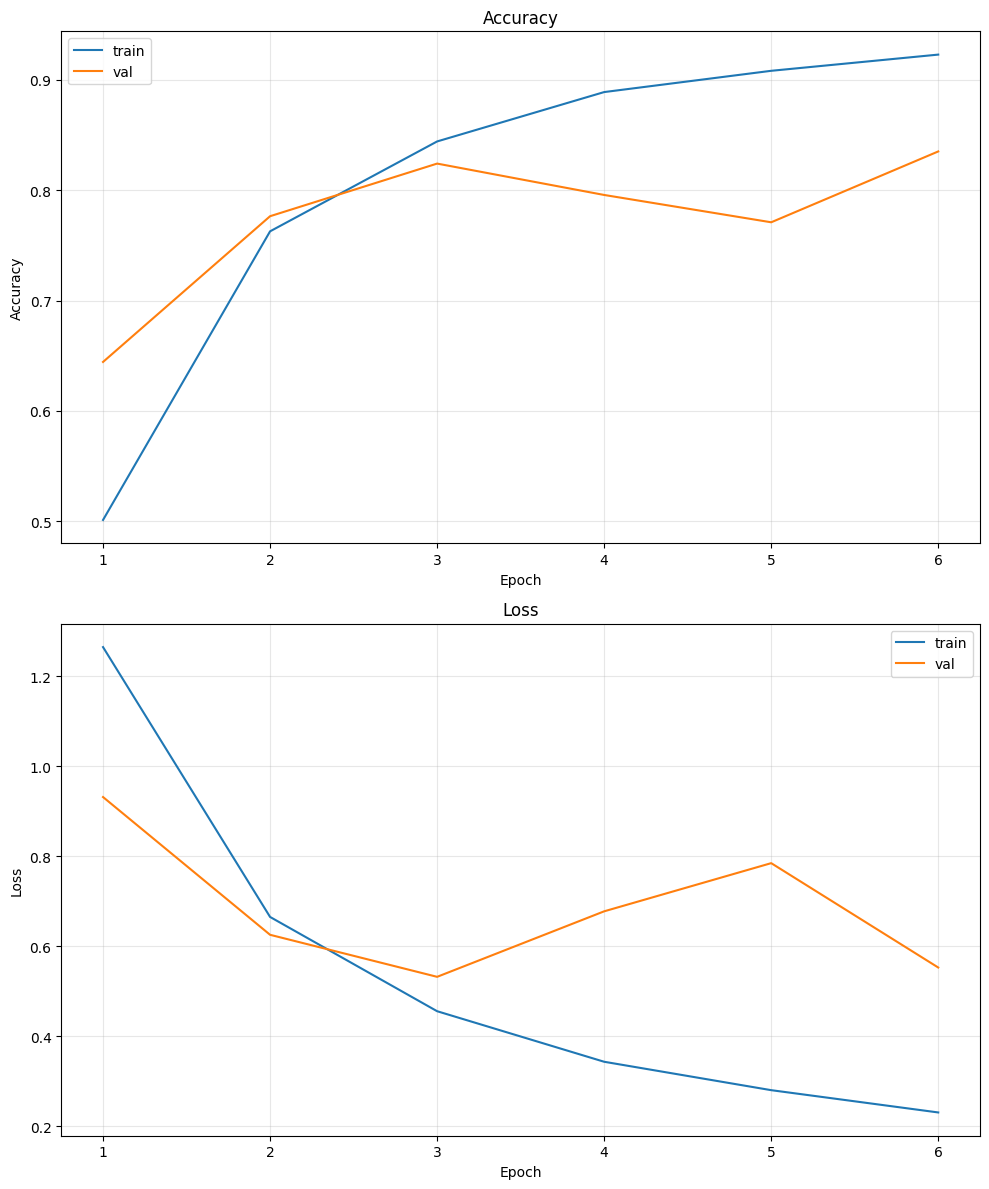

In [20]:
# 7) Plot accuracy and loss curves
def plot_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Handle possible key names
    acc = h.get("accuracy", h.get("acc"))
    val_acc = h.get("val_accuracy", h.get("val_acc"))
    loss = h.get("loss")
    val_loss = h.get("val_loss")

    plt.figure(figsize=(10, 12))

    # Accuracy
    plt.subplot(2, 1, 1)
    if acc is not None:
        plt.plot(epochs, acc, label="train")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(2, 1, 2)
    if loss is not None:
        plt.plot(epochs, loss, label="train")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_history(history)

### Inference on Test Set

In [21]:
# 8) Evaluate on test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Test accuracy: 0.862
              precision    recall  f1-score   support

        ABBR       1.00      0.56      0.71         9
        DESC       0.78      0.98      0.87       138
        ENTY       0.87      0.64      0.74        94
         HUM       0.95      0.86      0.90        65
         LOC       0.83      0.96      0.89        81
         NUM       0.98      0.86      0.92       113

    accuracy                           0.86       500
   macro avg       0.90      0.81      0.84       500
weighted avg       0.87      0.86      0.86       500



Topic-wise accuracy on test set:
ABBR: 0.5556 (n=9)
DESC: 0.9783 (n=138)
ENTY: 0.6383 (n=94)
HUM: 0.8615 (n=65)
LOC: 0.9630 (n=81)
NUM: 0.8584 (n=113)


<Figure size 1000x800 with 0 Axes>

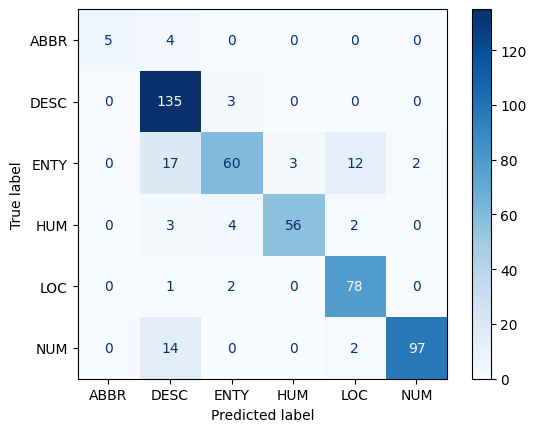

In [27]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# BiGRU Model
### Building and Training the Model

In [28]:
# 9) Define and compile BiGRU model (make sure EMBEDDING_DIM matches 100)
def build_bigru(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_bigru(nclasses, vocab_size, EMB_DIM, MAX_LEN, emb_matrix)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
# 10) Train the model with early stopping
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64, callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.5616 - loss: 1.0914 - val_accuracy: 0.7204 - val_loss: 0.7685
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.7998 - loss: 0.5602 - val_accuracy: 0.8176 - val_loss: 0.5167
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8578 - loss: 0.3849 - val_accuracy: 0.8378 - val_loss: 0.4913
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9060 - loss: 0.2746 - val_accuracy: 0.8405 - val_loss: 0.5286
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9335 - loss: 0.1937 - val_accuracy: 0.7993 - val_loss: 0.8478
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9452 - loss: 0.1590 - val_accuracy: 0.8396 - val_loss: 0.6393
Training time: 58.65437030792236


In [ ]:
model.summary()

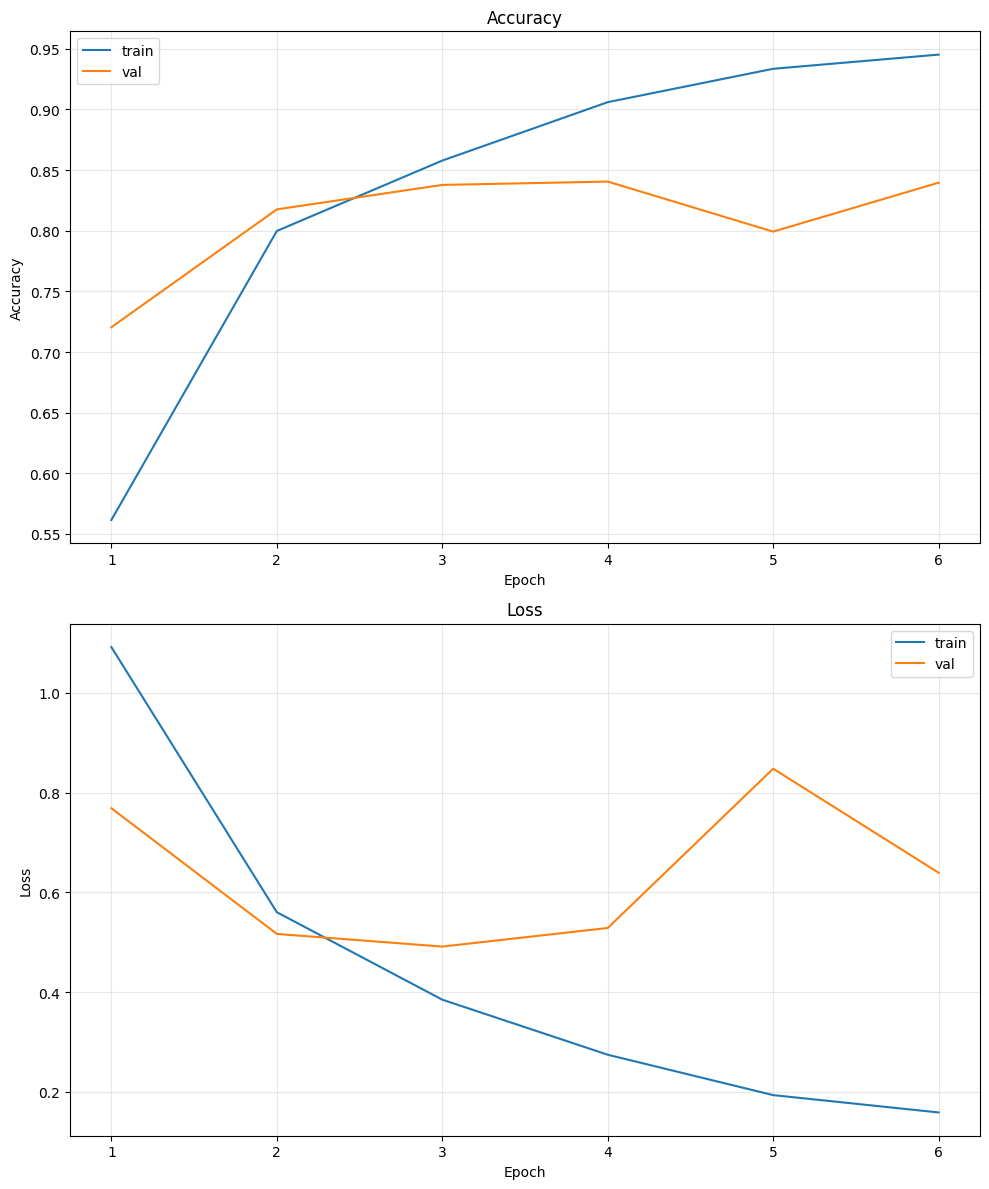

In [30]:
# 11) Plot accuracy and loss curves
plot_history(history)

### Inference on Test Set

In [31]:
# 12) Evaluate on test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
Test accuracy: 0.864
              precision    recall  f1-score   support

        ABBR       0.83      0.56      0.67         9
        DESC       0.80      0.96      0.88       138
        ENTY       0.91      0.53      0.67        94
         HUM       0.95      0.89      0.92        65
         LOC       0.93      0.93      0.93        81
         NUM       0.85      0.98      0.91       113

    accuracy                           0.86       500
   macro avg       0.88      0.81      0.83       500
weighted avg       0.87      0.86      0.85       500



Topic-wise accuracy on test set:
ABBR: 0.5556 (n=9)
DESC: 0.9638 (n=138)
ENTY: 0.5319 (n=94)
HUM: 0.8923 (n=65)
LOC: 0.9259 (n=81)
NUM: 0.9823 (n=113)


<Figure size 1000x800 with 0 Axes>

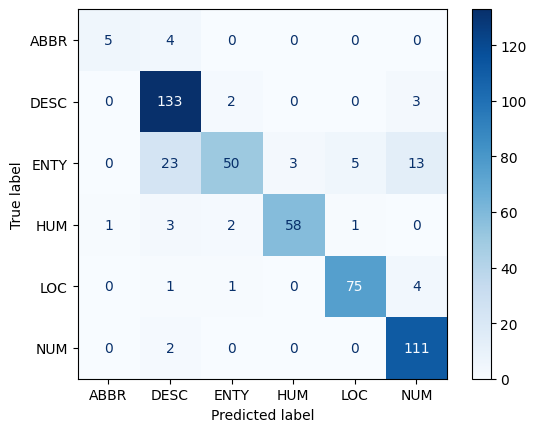

In [33]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()